In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))


In [2]:
import os
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import pickle

def load_in_paths(pp_file, PP_PATH, DAT_PATH,analysis_folder):
    mir = '_'.join(pp_file.split('_')[0:3])
    print(str(run_index+1) + '/' + str(len(os.listdir(PP_PATH))-1) + '-------------------------------------------------------------------------')
    print(pp_file)
    mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
    skip = False
    for item in ignore_list:
        if item == mouse_session_recording:
            skip = True

    save_path = PP_PATH + pp_file + analysis_folder
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    for file_ in os.listdir(dat_path + r"\video\tracking\\"):
        if 'task' in file_:
            if not 'clock' in file_:
                tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
        
    tracking_path = dat_path + r"\video\tracking\\"
   
    return mir,mouse_session_recording,save_path,tracking_path,dat_path
                        
def load_PPSEQ_data(PP_PATH,pp_file,dat_path):

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    ## LOAD 
    print("LOADING PPSEQ DATA")
    print('\n')
    #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
    assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

    # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
    latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

    # seq_type_log_proportions: log p of each type of sequence at each iteration
    seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

    # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
    # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
    neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")


    masking = False
    for dat_files in os.listdir(PP_PATH + pp_file):
        if 'unmasked_spikes' in dat_files:
            masking = True
            print('masking was used')

    if masking == True:
        #log_p_hist.csv: the history of the log_p of the model
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

        unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
    else:
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

        spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
        neuron_ids, spike_times= [], []
        with open(spikes_file) as f:
            for (i, line) in enumerate(f.readlines()):
                [neuron_id, spike_time] = line.split(' ', 1)
                spike_time = eval(spike_time.split('\n')[0])
                neuron_id = eval(neuron_id.split('\t')[0])
                spike_times.append(spike_time)
                neuron_ids.append(neuron_id)
        unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

    bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")


    # Opening JSON file
    f = open(PP_PATH + pp_file + r'\config_file.json')
    # returns JSON object as a dictionary
    config = eval(json.load(f))
    print(f'      done')

    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")

    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as 
    # a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span']
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

    ### load in data:
    for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
        if 'task' in sub_file:
            behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
    behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

    return assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start

def add_sleep_state_to_plot(nrem_start_ends,chunk_interval,offset,ax,c,alph):
    
    state_times = []
    for pair in nrem_start_ends-chunk_interval[0]:
        if pair[0] > 0:
            if pair[0] < np.diff(chunk_interval)[0]:
                x1 = pair[0]+offset
                if pair[1]<np.diff(chunk_interval)[0]:
                    x2 = pair[-1]+offset
                else:
                    x2 = np.diff(chunk_interval)[0]+offset
                print(x1,x2)
                state_times += [[x1,x2]]

                ax.axvspan(x1,x2, alpha = alph, color = c)
                
    return(state_times)


def match_state_to_replay_events(filtered_replay_clusters,rem_state_times):

    state_event = []
    for index, f_spike in enumerate(filtered_replay_clusters.first_spike_time):
        e_spike = filtered_replay_clusters.last_spike_time[index]
        c_state_event = 'nan'
        if len(rem_state_times) > 0:  
            for pair in rem_state_times:
                #if both inside
                if f_spike >= pair[0] and e_spike <= pair[-1]:
                    c_state_event=1
                    done = 1
                elif f_spike >= pair[0] and f_spike <= pair[-1]:
                    c_state_event=1      
        else:
            c_state_event = 0
            
        if c_state_event == 'nan':
            c_state_event = 0
            
        state_event += [c_state_event]
       
    return(state_event)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
#     plt.close()


In [3]:
# PP_PATH = r"Z:\projects\sequence_squad\revision_data\organised_data\ppseq_data\output_data\striatum\Post_sleep\\"

PP_PATH = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\Reveiw_Pre_sleep\second_attempt\\"

# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"

analysis_folder = r'\\_final_analysis_output\\'

stage = 'presleep'


if stage == 'presleep':
    stage = stage + '_'

In [ ]:
ignore_list= []


for run_index,pp_file in enumerate(os.listdir(PP_PATH)):
    
#     pp_file = '262_1_4_run_2106023_2357'
    
    if run_index >-1 and 'run' in pp_file:
        # load in paths for that specific mouse and recording
        mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH, analysis_folder)
        
        
#         if os.path.exists(dat_path + r'\\ephys\probeA\LFP\nrem_start_ends.npy'):

        ## load in PPseq output data
        assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,dat_path)


        ## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
        awake_file = False
        awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
        for file_ in os.listdir(awake_PP_path):
            if mouse_session_recording in file_:
                awake_file = file_
        if not awake_file:
            awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\awake\\"
            for file_ in os.listdir(awake_PP_path):
                if mouse_session_recording in file_:
                    awake_file = file_


        print(awake_file)
        ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
        neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
        colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
        spikes_df = unmasked_spikes_df
        colors += ['pink','lightblue', 'k'] 

        replay_analysis_path = PP_PATH + pp_file + analysis_folder

        # #load in spikes 
        # unfiltered_spikes_data

        offset = 0

        rem_length_tot = 0
        nrem_length_tot = 0
        rem_events_tot = 0
        nrem_events_tot = 0
        bg_time_tot = 0
        bg_events_tot = 0
        for chunk_file in os.listdir(replay_analysis_path):
            if 'chunk' in chunk_file:
                print(chunk_file)
                unfiltered_spikes_data = pd.read_csv(os.path.join(replay_analysis_path,chunk_file) + "\\unfiltered_spikes_data.csv")
                filtered_replay_clusters = pd.read_csv(os.path.join(replay_analysis_path,chunk_file) + "\\filtered_replay_clusters_df.csv")


                fig, ax = plt.subplots(1, 1,figsize=(20, 8))

                ax.set_title('blue = nrem       |      red = rem')


                # Define neuron order
                neuron_permute_loc = np.zeros(len(neuron_index))
                for i in range(len(neuron_index)):
                    neuron_permute_loc[i] = int(list(neuron_index).index(i))
                neuron_order = neuron_permute_loc[(unfiltered_spikes_data.neuron - 1).astype(int)]



                background_keep_mask = (unfiltered_spikes_data.sequence_type_adjusted < 0) | (unfiltered_spikes_data.sequence_type_adjusted >= 7.0)
                ax.scatter(unfiltered_spikes_data[background_keep_mask].timestamp, neuron_order[background_keep_mask],
                               marker='o', s=40, linewidth=0, color='lightgrey', alpha=0.3)
                background_remove_mask = (unfiltered_spikes_data.sequence_type_adjusted >= 0) * \
                                         (unfiltered_spikes_data.sequence_type_adjusted != 7.0) * \
                                         (unfiltered_spikes_data.sequence_type_adjusted != 8.0)
                c_ = np.array(colors)[unfiltered_spikes_data[background_remove_mask].sequence_type_adjusted.astype(int)]
                ax.scatter(unfiltered_spikes_data.timestamp[background_remove_mask], neuron_order[background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=0.3)

                chunk_interval = np.load(os.path.join(os.path.join(replay_analysis_path,chunk_file),'chunk_time_interval.npy'))


                ##### load in rem/nrem data
                try:
                    nrem_start_ends = np.load(dat_path + r'\\ephys\probeA\LFP\nrem_start_ends.npy')
                    rem_start_ends = np.load(dat_path + r'\\ephys\probeA\LFP\rem_start_ends.npy')
                except:
                    nrem_start_ends = np.load(dat_path + r'\\ephys\LFP\\' + stage + 'nrem_start_ends.npy')
                    rem_start_ends = np.load(dat_path + r'\\ephys\LFP\\' + stage + 'rem_start_ends.npy')

                nrem_state_times = add_sleep_state_to_plot(nrem_start_ends,chunk_interval,offset,ax,'blue',0.1)
                rem_state_times = add_sleep_state_to_plot(rem_start_ends,chunk_interval,offset,ax,'red',0.1)

                offset += np.diff(chunk_interval)[0]


                ##### save figs
                chunk_path = replay_analysis_path + chunk_file + '\\'

                SaveFig('state_scoring_plot.png',chunk_path)

                ##### decide what sleep state replay occurs in and add this to the dataframe, event has to start inside that state to be counted

                rem_events = match_state_to_replay_events(filtered_replay_clusters,rem_state_times)
                nrem_events = match_state_to_replay_events(filtered_replay_clusters,nrem_state_times)


                # add t df and save this out 

                filtered_replay_clusters['rem_events'] = rem_events
                filtered_replay_clusters['nrem_events'] = nrem_events
                filtered_replay_clusters.to_csv(chunk_path + 'filtered_replay_clusters_df.csv', index=False)

                print('--------------------')
                print(chunk_path)

                np.save(chunk_path + 'nrem_state_times.npy', nrem_state_times) 
                np.save(chunk_path + 'rem_state_times.npy', rem_state_times)




                # add up all time periods
                bg_time = np.diff(chunk_interval)[0]

                for item in rem_state_times:
                    rem_length_tot += np.diff(item)[0]
                    bg_time -= np.diff(item)[0]
                for item in nrem_state_times:
                    nrem_length_tot += np.diff(item)[0]
                    bg_time -= np.diff(item)[0]

                bg_time_tot += bg_time


                ## add up replay events:
                rem_events_tot += sum(rem_events)
                nrem_events_tot += sum(nrem_events)

                bg_events = (len(rem_events) - sum(nrem_events)) - sum(rem_events)
                bg_events_tot += bg_events

        # save out state replay rate data    
        if not nrem_events_tot == 0:
            n_rem_rate = nrem_events_tot/nrem_length_tot
        else:
            n_rem_rate = 'nan'

        if not rem_events_tot == 0:
            rem_rate = rem_events_tot/rem_length_tot
        else:
            rem_rate = 'nan'

        if not bg_events_tot == 0:
            bg_rate = bg_events_tot/bg_time_tot 
        else:
            bg_rate = 'nan'

        rates_df = pd.DataFrame({'n_rem_rate': [n_rem_rate],'rem_rate': [rem_rate],'bg_rate': [bg_rate]})
        rates_df.to_csv(replay_analysis_path + 'state_rates_df.csv', index=False)
            
#     break






1/19-------------------------------------------------------------------------
136_1_3_run_2908025_2041
LOADING PPSEQ DATA




In [38]:
chunk_path + 'filtered_replay_clusters_df.csv'

'Z:\\projects\\sequence_squad\\revision_data\\organised_data\\ppseq_data\\output_data\\striatum\\Post_sleep\\\\seq007_1_4_run_2405025_0900\\\\_final_analysis_output\\\\chunk2_14900to16400\\filtered_replay_clusters_df.csv'

In [35]:
chunk_path + 'filtered_replay_clusters_df.csv'

'Z:\\projects\\sequence_squad\\revision_data\\organised_data\\ppseq_data\\output_data\\striatum\\Post_sleep\\\\seq007_1_3_run_2905025_0930\\\\_final_analysis_output\\\\chunk3_14500to15500\\filtered_replay_clusters_df.csv'

# Across mice state rates

In [236]:
#### across mice

n_rem_rates = []
rem_rates = []
bg_rates = []

for run_index,pp_file in enumerate(os.listdir(PP_PATH)[15::]):
    if run_index >-1 and 'run' in pp_file:
        
        mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH)
        
        
        if os.path.exists(dat_path + r'\\ephys\LFP\sleep_state_score\nrem_start_ends.npy'):

            replay_analysis_path = PP_PATH + pp_file + r"\\analysis_output\\"
            a = pd.read_csv(replay_analysis_path + 'state_rates_df.csv')
            
            n_rem_rates+=[a.n_rem_rate[0]]
            rem_rates+=[a.rem_rate[0]]
            bg_rates+=[a.bg_rate[0]]

1/37-------------------------------------------------------------------------
238_1_5_run_0407023_1954
2/37-------------------------------------------------------------------------
238_1_6_run_1906023_0628
3/37-------------------------------------------------------------------------
255_1_1_run_2006023_0409
4/37-------------------------------------------------------------------------
255_1_2_run_2106023_1837
5/37-------------------------------------------------------------------------
255_1_4_run_1906023_0133
6/37-------------------------------------------------------------------------
256_1_1_run_1906023_0053
7/37-------------------------------------------------------------------------
262_1_1_run_1806023_2129
8/37-------------------------------------------------------------------------
262_1_2_run_2006023_0238
9/37-------------------------------------------------------------------------
262_1_4_run_2106023_2357
10/37--------------------------------------------------------------------

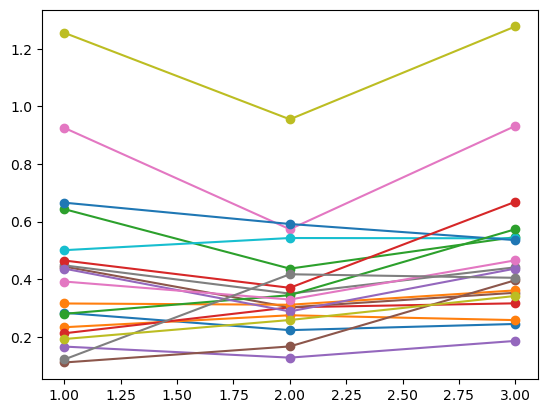

In [242]:
for i in range(len(n_rem_rates)):
    plt.plot([1,2,3],[n_rem_rates[i],rem_rates[i],bg_rates[i]],'-o')

In [ ]:
# for each replay event plot the movement
# plot the normalised delta 
# plot the theta ratio - 

In [239]:
plot_df = pd.DataFrame({'n_rem_rates': n_rem_rates,'rem_rates': rem_rates,'bg_rates': bg_rates})

In [234]:
plt.figure(figsize=(5, 10))
ax = sns.boxplot(x="experiment", y="perfect score", linewidth=1, saturation = 1, data=df_perfect_score, 
                 order=order,  showfliers=False, palette = my_cmap, width = 0.2,
                 medianprops={"linewidth": 1, "solid_capstyle": "butt"},boxprops = {"facecolor": 'none'}) 

ax.plot([-.2]*len(df_perfect_score[df_perfect_score.experiment == 'baseline']['perfect score']),df_perfect_score[df_perfect_score.experiment == 'baseline']['perfect score'],'o',color = '#56BEC1',markersize = 10,alpha = 0.8)
ax.plot([0.8]*len(df_perfect_score[df_perfect_score.experiment == 'saline']['perfect score']),df_perfect_score[df_perfect_score.experiment == 'saline']['perfect score'],'o',color = '#56BEC1',markersize = 10,alpha = 0.8)
ax.plot([1.8]*len(df_perfect_score[df_perfect_score.experiment == 'muscimol']['perfect score']),df_perfect_score[df_perfect_score.experiment == 'muscimol']['perfect score'],'o',color = '#56BEC1',markersize = 10,alpha = 0.8)




[0.2833333333333333,
 0.2333333333333333,
 0.6431818181818182,
 0.2123402818641834,
 0.166146982575403,
 0.4438469999556624,
 0.925197592219092,
 0.4479727333285478,
 1.2551912320355945,
 0.5007859838022825,
 0.6656449765600847,
 0.3157894736842105,
 0.28,
 0.4648648648648649,
 0.4366806136790503,
 0.1109742796783745,
 0.3919354838709677,
 0.121638483829624,
 0.1924414962094158]

In [114]:
PP_PATH

'Z:\\projects\\sequence_squad\\organised_data\\ppseq_data\\output_data\\striatum\\New_Post_sleep\\\\'

In [235]:
bg_rates

[0.2446632692623861,
 0.2580428498442401,
 0.5462096986715284,
 0.3162992350051553,
 0.1858182196591743,
 0.3529484714668473,
 0.9320414044771342,
 0.4412694396455194,
 1.277275486574283,
 0.5419111173673288,
 0.5356871084656585,
 0.3612214932517527,
 0.5735329450216178,
 0.6687644381691604,
 0.436923104655082,
 0.3965144119285693,
 0.4655600180107679,
 0.404874444763129,
 0.3418314783023362]

In [204]:
replay_analysis_path

'Z:\\projects\\sequence_squad\\organised_data\\ppseq_data\\finalised_output\\striatum\\paper_submission\\post_sleep\\\\255_1_1_run_2006023_0409\\\\analysis_output\\\\'

In [129]:
rem_state_times = []

In [86]:
for index,event in rem_events:
    if event == nrem_events[index]:
        # this meas the event falls into both



In [115]:
np.sum(rem_events)

np.sum(nrem_events)

69

In [112]:
filtered_replay_clusters

,cluster_seq_type,num_spikes,num_neurons,first_spike_time,event_length,last_spike_time,cluster_spike_times,cluster_neurons,spike_plotting_order,coactive_cluster_group,rem_events,nrem_events
0,2,10,1213.3466,1213.2128,0.1338,1213.3466,"[1213.2128, 1213.2257, 1213.2691, 1213.2854, 1...","[7.0, 7.0, 7.0, 7.0, 21.0, 44.0, 44.0, 55.0, 1...",[ 58. 58. 58. 58. 52. 38. 38. 115. 46. ...,0.0,0,0
1,2,5,1246.3715,1245.5777,0.7938,1246.3715,"[1246.3715, 1246.1014, 1246.1383, 1245.5777, 1...","[5.0, 44.0, 44.0, 102.0, 102.0]",[94. 38. 38. 46. 46.],1.0,0,0
2,2,36,1271.3310,1270.9381,0.3929,1271.3310,"[1271.2254, 1271.1639, 1271.1184, 1271.1685, 1...","[4.0, 5.0, 12.0, 20.0, 20.0, 23.0, 41.0, 46.0,...",[ 42. 94. 4. 86. 86. 119. 45. 41. 41. ...,2.0,0,0
3,2,9,1300.9456,1300.0387,0.9069,1300.9456,"[1300.4561, 1300.5587, 1300.7037, 1300.7505, 1...","[41.0, 41.0, 41.0, 41.0, 46.0, 46.0, 52.0, 54....",[45. 45. 45. 45. 41. 41. 27. 51. 51.],3.0,0,0
4,2,33,1312.0769,1311.0613,1.0156,1312.0769,"[1311.6418, 1311.6136, 1311.6467, 1311.7189, 1...","[18.0, 41.0, 41.0, 41.0, 44.0, 44.0, 44.0, 55....",[122. 45. 45. 45. 38. 38. 38. 115. 115. ...,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
340,6,128,1784.7798,1783.6655,1.1143,1784.7798,"[1784.7685, 1784.1709, 1784.1847, 1784.1979, 1...","[8.0, 56.0, 56.0, 56.0, 56.0, 57.0, 57.0, 57.0...",[ 62. 108. 108. 108. 108. 105. 105. 105. 105. ...,230.0,1,0
341,6,48,1787.1267,1786.0388,1.0879,1787.1267,"[1786.0733, 1786.106, 1786.0388, 1787.1267, 17...","[1.0, 1.0, 5.0, 5.0, 56.0, 56.0, 57.0, 57.0, 5...",[ 29. 29. 94. 94. 108. 108. 105. 105. 105. ...,155.0,1,0
342,6,410,1790.2852,1787.7696,2.5156,1790.2852,"[1788.6426, 1788.9626, 1788.5757, 1788.6263, 1...","[1.0, 15.0, 27.0, 27.0, 52.0, 56.0, 56.0, 56.0...",[ 29. 25. 28. 28. 27. 108. 108. 108. 108. ...,116.0,1,0
343,6,13,1795.4951,1795.4845,0.0106,1795.4951,"[1795.4942, 1795.4951, 1795.4845, 1795.4897, 1...","[57.0, 57.0, 61.0, 61.0, 61.0, 67.0, 69.0, 71....",[105. 105. 112. 112. 112. 103. 98. 101. 101. ...,231.0,1,0


In [31]:


## plot replay rate in each

## plot this across mice 


2004.6020747943912 2064.6020747943912
2204.6020747943912 2400


In [16]:

# plot replay rate in each sleep state


In [80]:
### chunk is in ephys time 

## rem and nrem are relative to camera start time

## so I need to accoutn for this offset, possibly its easier to change the way I save thes eout so that theya re in ephys timestamps


nrem_start_ends

array([[1560, 1580],
       [1880, 1900],
       [1920, 2300],
       [2320, 2600],
       [2620, 2940],
       [3120, 3380],
       [3480, 3680],
       [3880, 4420],
       [4440, 4480],
       [4500, 4560],
       [4920, 5000],
       [5020, 5100],
       [5120, 5280],
       [5440, 5520],
       [5540, 5560],
       [5580, 5640]])

In [ ]:
### add rem and nrem to plot




In [75]:
dat_path

'Z:\\projects\\sequence_squad\\organised_data\\animals\\\\EJT136_implant1\\recording3_11-11-2021'

In [74]:
tracking_path.split

'Z:\\projects\\sequence_squad\\organised_data\\animals\\\\EJT136_implant1\\recording3_11-11-2021\\video\\tracking\\\\2_task\\'

In [28]:
os.path.join(replay_analysis_path,chunk_file)

'Z:\\projects\\sequence_squad\\organised_data\\ppseq_data\\finalised_output\\striatum\\paper_submission\\post_sleep\\\\136_1_3_run_1007023_2048\\\\analysis_output\\\\log_l_curve.png'

In [ ]:
### plot each chunk 
## load in sleep state score data and overlay this 
# analyse these